1031
4096
4096
4096


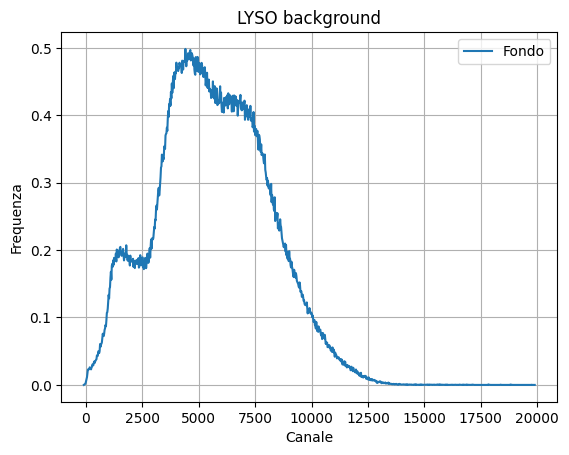

In [29]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Caratterizzazione Cristalli\LYSO\Fondo LYSO\LYSO-fondo-newgate.CSV', sep=';')
data1 = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Caratterizzazione Cristalli\LYSO\Sodio\SpettroNa_2ndRun_LYSO.csv', sep=' \t', engine='python')

print(len(data['Channel']))
print(len(data1['Channel']))

channel_back = np.array(data['Channel']) #taglio i dati per avere lo stesso numero di elementi
counts_back = np.array(data['Counts'])
time_back = 6335 #s
frequency_back = counts_back/time_back

channel_Na = np.array(data1['Channel'])
counts_Na = np.array(data1['Counts'])
time_Na = 300 #s
frequency_Na = counts_Na/time_Na

# devo allungare il fondo con tanti zeri
allungo_x = np.arange(20510, 81800, 20)
allungo_y = np.zeros(len(allungo_x))
channel_back = np.concatenate((channel_back, allungo_x))
frequency_back = np.concatenate((frequency_back, allungo_y))

print(len(channel_back))
print(len(channel_Na))

plt.plot(channel_back[:1000], frequency_back[:1000], label='Fondo')
plt.xlabel('Canale')
plt.ylabel('Frequenza')
plt.title('LYSO background')
plt.legend()
plt.grid()
plt.show()

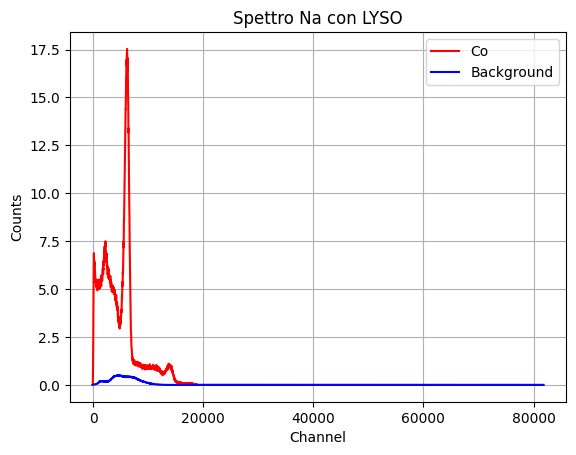

In [30]:
plt.plot(channel_Na, frequency_Na, marker='', linestyle='-', color='red', label='Co')
plt.plot(channel_back, frequency_back, marker='', linestyle='-', color='blue', label='Background')
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.title('Spettro Na con LYSO')
plt.legend()
plt.grid()
plt.show()

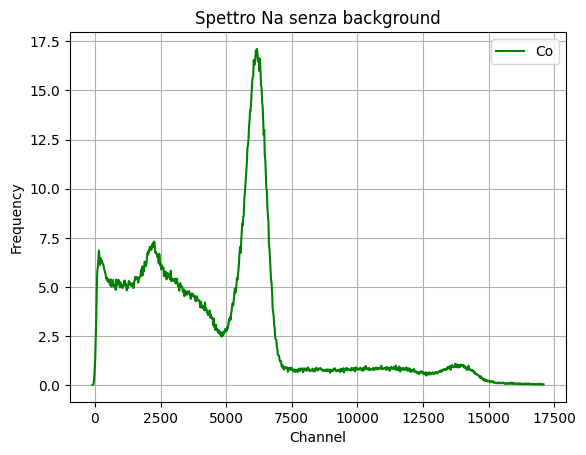

In [31]:
channel = channel_back
frequency = frequency_Na - frequency_back

for i in range(len(frequency)):
    if frequency[i] < 0:
        frequency[i] = 0

plt.plot(channel[:860], frequency[:860], marker='', linestyle='-', color='green', label='Co')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.legend()
plt.title('Spettro Na senza background')
plt.grid()

In [32]:
from iminuit import Minuit
from iminuit.cost import LeastSquares
from scipy.stats import norm, chi2


def repeat_fit(ls, left_bound, right_bound, mu, sigma, A, ampiezza_picco_limite, dis=False, limit_ADC=100):
    '''
    ampiezza picco limite = è la ampiezza dell'intorno di mu in cui è accettabile avere il picco
    '''
    peak_list = []
    error_peak_list = []
    sigma_list = []
    error_sigma_list = []
    for delta_ADC in np.arange(0, abs(right_bound-left_bound)/2+limit_ADC, 10):
        ls.mask = (channel > left_bound+delta_ADC) & (channel < right_bound-delta_ADC)
        m = Minuit(ls, mu=mu, sigma=sigma, A=A)
        m.migrad()
        m.hesse()
        p_value = (1. - chi2.cdf (m.fval, df = m.ndof))
        if p_value > 0.05 and m.valid == True:
            if m.values['mu'] < (mu+ampiezza_picco_limite/2) and m.values['mu'] > (mu-ampiezza_picco_limite/2):    
                peak_list.append(m.values['mu'])
                error_peak_list.append(m.errors['mu'])
                sigma_list.append(m.values['sigma'])
                error_sigma_list.append(m.errors['sigma'])
                if dis==True: display(m)
        ls.mask = None
    for delta_ADC in np.arange(0, abs(right_bound-left_bound)/2+limit_ADC, 10):
        ls.mask = (channel > left_bound+delta_ADC) & (channel < right_bound-delta_ADC/2)
        m = Minuit(ls, mu=mu, sigma=sigma, A=A)
        m.migrad()
        m.hesse()
        p_value = (1. - chi2.cdf (m.fval, df = m.ndof))
        if p_value > 0.05 and m.valid == True:
            if m.values['mu'] < (mu+ampiezza_picco_limite/2) and m.values['mu'] > (mu-ampiezza_picco_limite/2):    
                peak_list.append(m.values['mu'])
                error_peak_list.append(m.errors['mu'])
                sigma_list.append(m.values['sigma'])
                error_sigma_list.append(m.errors['sigma'])
                if dis==True: display(m)
        ls.mask = None
    for delta_ADC in np.arange(0, abs(right_bound-left_bound)/2+limit_ADC, 10):
        ls.mask = (channel > left_bound+delta_ADC/2) & (channel < right_bound-delta_ADC)
        m = Minuit(ls, mu=mu, sigma=sigma, A=A)
        m.migrad()
        m.hesse()
        p_value = (1. - chi2.cdf (m.fval, df = m.ndof))
        if p_value > 0.05 and m.valid == True:
            if m.values['mu'] < (mu+ampiezza_picco_limite/2) and m.values['mu'] > (mu-ampiezza_picco_limite/2):    
                peak_list.append(m.values['mu'])
                error_peak_list.append(m.errors['mu'])
                sigma_list.append(m.values['sigma'])
                error_sigma_list.append(m.errors['sigma'])
                if dis==True: display(m)
        ls.mask = None
    return np.array(peak_list), np.array(error_peak_list), np.array(sigma_list), np.array(error_sigma_list)

In [33]:
def func(x, mu, sigma, A):
    return A * norm.pdf(x, mu, sigma)

error = np.sqrt(counts_Na)/time_Na

ls = LeastSquares(channel, frequency, error, func)

peak_list511, error_peak_list511, sigma_list511, err_sigma_list511 = repeat_fit(ls, 5400, 6750, 6170, 400, 16.5, 200)

print(peak_list511)
print(error_peak_list511)

[6157.29585897 6157.17454661 6160.59421407 6160.40102742 6162.36843094
 6161.9913235  6172.56958735 6160.39503139 6167.9931917  6165.88622522
 6154.5522486  6155.75733194 6180.1433701  6098.92907054 6154.29372948
 6154.95295254 6155.88745227 6155.88745227 6157.75379417 6158.00236795
 6159.49936904 6159.49936904 6161.8618037  6161.82053724 6161.79093656
 6161.79093656 6161.68356169 6161.68894907 6164.28078436 6164.97156205
 6166.11509386 6164.22079121 6173.4711469  6173.4711469  6174.73308086
 6173.2997937  6157.13790024 6157.05921528 6185.19233804 6185.19233804
 6183.20495018 6183.20495018 6192.50442045 6192.50442045 6201.01084744
 6201.01084744 6243.28286478 6243.28286478 6228.62934338 6228.62934338
 6241.88149565 6241.88149565]
[ 3.03146914  2.98616844  3.47516787  3.43307555  3.96506057  3.8996783
  8.04875724  8.03861017 11.16976251 10.92894056 13.88754458 15.20704381
 31.14667458 35.5552581   2.0676399   2.11705658  2.24678895  2.24678895
  2.38111495  2.41517494  2.58865166  2.58

In [34]:
peak_list1274_5, error_peak_list1274_5, sigma_list1274_5, err_sigma_list1274_5 = repeat_fit(ls, 13100, 14500, 13800, 300, 1.3, 200, dis=False, limit_ADC=300)

print(peak_list1274_5)
print(error_peak_list1274_5)

[13802.12746974 13809.63047259 13809.63047259 13811.23249706
 13811.23249706 13817.50843855 13817.50843855 13819.88069176
 13819.88069176 13819.10194366 13819.10194366 13817.9228451
 13817.9228451  13823.42784335 13823.42784335 13823.61670976
 13823.61670976 13827.17592131 13827.17592131 13817.33753221
 13817.33753221 13812.92503323 13812.92503323 13820.48682818
 13820.48682818 13844.75471497 13844.75471497 13861.24365136
 13861.24365136 13862.51534751 13862.51534751 13880.51131253
 13880.51131253 13877.98421965 13877.98421965 13831.02338102
 13831.02338102 13786.01180806 13786.01180806 13778.22103166
 13778.22103166 13802.12746974 13804.86511464 13809.63047259
 13810.65083382 13810.65083382 13813.04985498 13813.51747653
 13817.01316491 13817.01316491 13815.98591181 13819.51460694
 13819.706516   13819.706516   13821.56220161 13820.86185174
 13821.1169297  13821.1169297  13824.94086669 13824.95112214
 13826.50180409 13826.50180409 13842.0803683  13842.0803683
 13851.17706282 13851.1461

In [35]:
def weighted_mean(values, errors):
    mean = np.sum(values/(errors**2))/np.sum(1/(errors**2))
    error_mean = np.sqrt((abs(np.max(values) - np.min(values))/2)**2 + (1/np.sum(1/(errors**2))))
    return mean, error_mean

# first peak at 511 KeV
mean511, error_mean511 = weighted_mean(peak_list511, error_peak_list511)
print(mean511, error_mean511)

# second peak at 1274.5 KeV
mean1274_5, error_mean1274_5 = weighted_mean(peak_list1274_5, error_peak_list1274_5)
print(mean1274_5, error_mean1274_5)

6160.138302936105 72.17921173212947
13820.506268852114 57.89329663184249


In [36]:
picchi1 = np.array([105.66583235975234, 1594.988073891837, 3868.3915320030005, mean511, mean1274_5, 20471.085272822635])
err_picchi1 = np.array([11.950191050444797, 10, 88.07032123601091, error_mean511, error_mean1274_5, 285.515653071855])
energia1 = np.array([14.4, 122.1, 300.1, 511, 1274.5, 2104])

def line(x, m, q):
    return m*x + q

ls3 = LeastSquares(energia1, picchi1, err_picchi1, line)
m3 = Minuit(ls3, m=1, q=0)
m3.migrad()
m3.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 567.6 (χ²/ndof = 141.9)    │              Nfcn = 41               │
│ EDM = 1.57e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   10.99   │   0.04    │            │            │         │         │       │
│ 1 │ q    │    127    │     9     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       m       q │
├───┼─────────────────┤
│ m │  0.0018 -0.1909 │
│ q │ -0.1909    76.9 │
└───┴─────────────────┘

In [37]:
def parabola(x, a, x0, y0):
    return y0 + a*(x-x0)**2

ls4 = LeastSquares(energia1, picchi1, err_picchi1, parabola)
m4 = Minuit(ls4, a=-1, x0=2500, y0=25000)
m4.migrad()
m4.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 36.16 (χ²/ndof = 12.1)     │              Nfcn = 568              │
│ EDM = 2.97e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │ -2.04e-3  │  0.09e-3  │            │            │         │         │       │
│ 1 │ x0   │  3.33e3   │  0.12e3   │            │            │         │         │       │
│ 2 │ y0   │  22.5e3   │   0.6e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────────────────┐
│    │            a           x0           y0 │
├────┼────────────────────────────────────────┤
│  a │     7.74e-09 10.247306e-3 53.951738e-3 │
│ x0 │ 10.247306e-3     1.37e+04      0.073e6 │
│ y0 │ 53.951738e-3      0.073e6     3.95e+05 │
└────┴────────────────────────────────────────┘

In [38]:
def func1(x, a, b):
    return b*(1 - np.exp(-a*x))

ls5 = LeastSquares(energia1, picchi1, err_picchi1, func1)
m5 = Minuit(ls5, a=0.001, b=25000)
m5.migrad()
m5.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 53.8 (χ²/ndof = 13.4)      │              Nfcn = 115              │
│ EDM = 1.08e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │ 0.320e-3  │ 0.012e-3  │            │            │         │         │       │
│ 1 │ b    │  41.3e3   │   1.4e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────┐
│   │               a               b │
├───┼─────────────────────────────────┤
│ a │        1.51e-10 -16.70706263e-3 │
│ b │ -16.70706263e-3        1.87e+06 │
└───┴─────────────────────────────────┘

[14.4, 122.1, 300.1, 511.0, 1274.5, 2104.0]
[105.66583235975234, 1594.988073891837, 3868.3915320030005, 6160.138302936105, 13820.506268852114, 20471.085272822635]
[11.950191050444797, 10.0, 88.07032123601091, 72.17921173212947, 57.89329663184249, 285.515653071855]
Pametri esponenziale: <ValueView a=0.0003201079986907511 b=41311.14831754631>


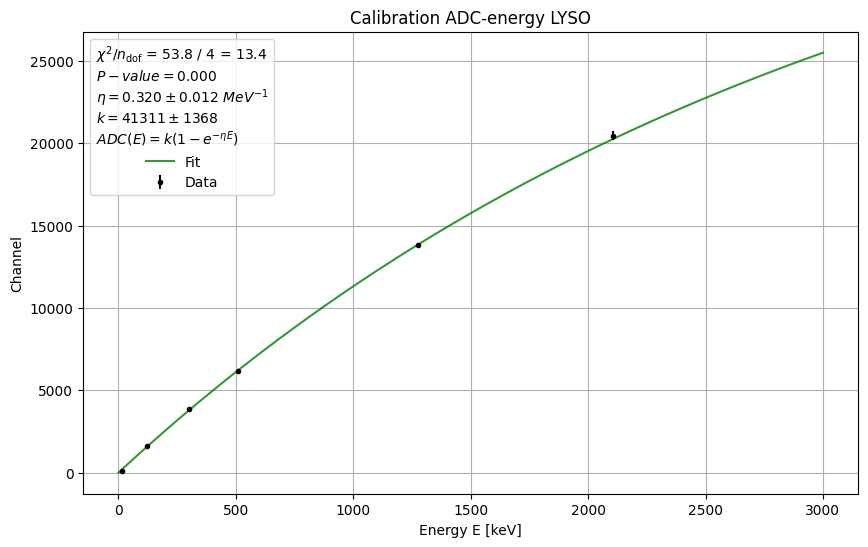

In [39]:
# plot dell'esponenziale e della parabola sovrapposti

x = np.linspace(0, 3000, 1000)
y = func1(x, *m5.values)

plt.subplots(figsize=(10, 6))
plt.plot(x, y, label='Fit', color='green', alpha=0.8)
plt.errorbar(energia1, picchi1, err_picchi1, fmt='.', linestyle='', label='Data', color='black')

print(f'[{energia1[0]}, {energia1[1]}, {energia1[2]}, {energia1[3]}, {energia1[4]}, {energia1[5]}]')
print(f'[{picchi1[0]}, {picchi1[1]}, {picchi1[2]}, {picchi1[3]}, {picchi1[4]}, {picchi1[5]}]')
print(f'[{err_picchi1[0]}, {err_picchi1[1]}, {err_picchi1[2]}, {err_picchi1[3]}, {err_picchi1[4]}, {err_picchi1[5]}]')

p_value = (1. - chi2.cdf(m5.fval, df=m5.ndof))


fit_info = [f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m5.fval:.1f} / {m5.ndof:.0f} = {m5.fval/m5.ndof:.1f}",]
fit_info.append(f"$P-value = {p_value:.3f}$")
fit_info.append(f"$\eta = {m5.values['a']*10**3:.3f} \pm {m5.errors['a']*10**3:.3f}$"+" $MeV^{-1}$")
fit_info.append(f"$k = {m5.values['b']:.0f} \pm {m5.errors['b']:.0f}$")
fit_info.append(r"$ADC(E) = k(1-e^{-\eta E})$")


plt.xlabel('Energy E [keV]')
plt.ylabel('Channel')
plt.title('Calibration ADC-energy LYSO')
plt.grid()
plt.legend(title="\n".join(fit_info), frameon=True)
plt.savefig('calibrazione_LYSO.png')

print(f'Pametri esponenziale: {m5.values}')

energia picco 1 (88keV?): 106.8409456761046 +- 9.264067282009002, sigma = 2.0337660665196244
energia picco 2 (290keV oppure 395keV): 379.16798091339524 +- 19.77376284539701, sigma = 0.8006578823863147
energia picco 3 (597keV?): 557.9593299743381 +- 36.69312505840824, sigma = 1.0639777877604284


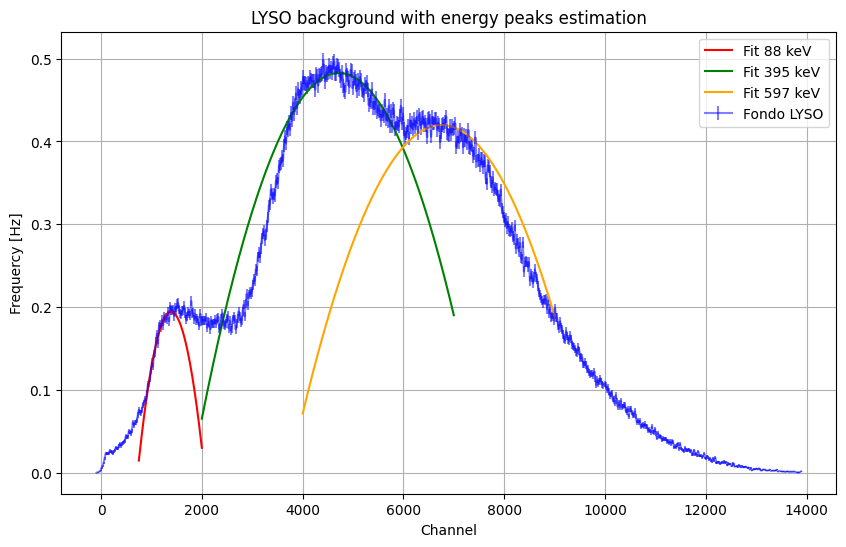

In [40]:
# estrapolazione energie dai picchi del fondo del LYSO

import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter(x=channel_back, y=frequency_back, mode='lines', name='Fondo LYSO')])
fig.show()

def parabola(x, a, x0, y0):
    return y0 + a*(x-x0)**2

error = np.sqrt(counts_back)/time_back
error = np.concatenate((error, np.zeros(len(allungo_x))))[:len(channel_back)]

ls88 = LeastSquares(channel_back, frequency_back, error, parabola)
m88 = Minuit(ls88, a=-1, x0=1530, y0=0.2)
ls88.mask = (channel_back > 900) & (channel_back < 1200)
m88.migrad()
m88.hesse()

ls290 = LeastSquares(channel_back, frequency_back, error, parabola)
m290 = Minuit(ls290, a=-1, x0=4630, y0=np.max(frequency_back))
ls290.mask = (channel_back > 3800) & (channel_back < 5700)    
m290.migrad()
m290.hesse()

ls597 = LeastSquares(channel_back, frequency_back, error, parabola)
m597 = Minuit(ls597, a=-1, x0=6700, y0=0.43)
ls597.mask = (channel_back > 6000) & (channel_back < 7550)
m597.migrad()
m597.hesse()

def energy(x, k, eta):
    return -np.log(1 - x/k)/eta

def err_energy(x, err_x, k, eta, err_k, err_eta):
    return np.sqrt((err_eta/eta**2 * np.log(1-x/k))**2 + (x/(eta*k**2)/(1-x/k))**2 * err_k**2 + (err_x/(k*eta*(1-x/k)))**2)

ADC_peak_88keV = m88.values['x0'] 
ADC_error_88keV = m88.errors['x0']

ADC_peak_290keV = m290.values['x0']
ADC_error_290keV = m290.errors['x0']

ADC_peak_597keV = m597.values['x0']
ADC_error_597keV = m597.errors['x0']

energy_peak1 = energy(ADC_peak_88keV, m5.values['b'], m5.values['a']) 
error_energy_peak1 = err_energy(ADC_peak_88keV, ADC_error_88keV, m5.values['b'], m5.values['a'], m5.errors['b'], m5.errors['a'])

energy_peak2 = energy(ADC_peak_290keV, m5.values['b'], m5.values['a'])
error_energy_peak2 = err_energy(ADC_peak_290keV, ADC_error_290keV, m5.values['b'], m5.values['a'], m5.errors['b'], m5.errors['a'])

energy_peak3 = energy(ADC_peak_597keV, m5.values['b'], m5.values['a'])
error_energy_peak3 = err_energy(ADC_peak_597keV, ADC_error_597keV, m5.values['b'], m5.values['a'], m5.errors['b'], m5.errors['a'])

print(f'energia picco 1 (88keV?): {energy_peak1} +- {error_energy_peak1}, sigma = {abs(energy_peak1-88)/error_energy_peak1}')
print(f'energia picco 2 (290keV oppure 395keV): {energy_peak2} +- {error_energy_peak2}, sigma = {abs(energy_peak2-395)/error_energy_peak2}')
print(f'energia picco 3 (597keV?): {energy_peak3} +- {error_energy_peak3}, sigma = {abs(energy_peak3-597)/error_energy_peak3}')

# plot del fondo con le parabole sopra
plt.subplots(figsize=(10, 6))
xaxis1 = np.linspace(750, 2000, 1000)
xaxis2 = np.linspace(2000, 7000, 1000)
xaxis3 = np.linspace(4000, 9000, 1000)
plt.errorbar(channel_back[0:700], frequency_back[0:700], yerr=error[0:700], label='Fondo LYSO', color='blue', alpha=0.5)
plt.plot(xaxis1, parabola(xaxis1, *m88.values), label='Fit 88 keV', color='red')
plt.plot(xaxis2, parabola(xaxis2, *m290.values), label='Fit 395 keV', color='green')
plt.plot(xaxis3, parabola(xaxis3, *m597.values), label='Fit 597 keV', color='orange')
plt.xlabel('Channel')
plt.ylabel('Frequercy [Hz]')
plt.title('LYSO background with energy peaks estimation')
plt.grid()
plt.legend()
plt.show()

In [41]:
# RISOLUZIONE ENERGETICA

sigma_511, err_sigma_511 = weighted_mean(sigma_list511, err_sigma_list511)
sigma_1274_5, err_sigma_1274_5 = weighted_mean(sigma_list1274_5, err_sigma_list1274_5)

print(sigma_511, err_sigma_511)
print(sigma_1274_5, err_sigma_1274_5)

sigma = np.array([66.9979830839159, 161.07163628792472, 337.1587201329192, sigma_511, sigma_1274_5, 763.4127995106787])
err_sigma = np.array([16.40565509818746, 12.472000391279426, 106.08007316145746, err_sigma_511, err_sigma_1274_5, 434.07051836710406])

R = 2.35 * sigma/picchi1
err_R = 2.35 * np.sqrt((err_sigma/picchi1)**2 + (sigma*err_picchi1/picchi1**2)**2)
print(R)
print(err_R)

# fit esponenziale
def exp_R(x, k, q):
    return k/np.sqrt(x) + q

ls6 = LeastSquares(energia1, R, err_R, exp_R)
m6 = Minuit(ls6, k=1, q=1)
m6.migrad()
m6.hesse()
display(m6)

394.27877938554803 126.71343818477949
746.4863306098824 382.6679982355008
[1.49003    0.23731735 0.20481975 0.15041142 0.12693044 0.08763678]
[0.40189559 0.01843595 0.06461082 0.04837139 0.06506996 0.04984458]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.126 (χ²/ndof = 1.3)      │              Nfcn = 43               │
│ EDM = 3.13e-22 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ k    │    2.3    │    0.6    │            │            │         │         │       │
│ 1 │ q    │   0.04    │   0.05    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       k       q │
├───┼─────────────────┤
│ k │   0.327 -0.0243 │
│ q │ -0.0243 0.00204 │
└───┴─────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.673 (χ²/ndof = 0.9)      │              Nfcn = 54               │
│ EDM = 6.02e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  0.23e3   │  0.19e3   │            │            │         │         │       │
│ 1 │ b    │    5.6    │    1.8    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │ 3.67e+04   -286.0 │
│ b │   -286.0     3.35 │
└───┴───────────────────┘

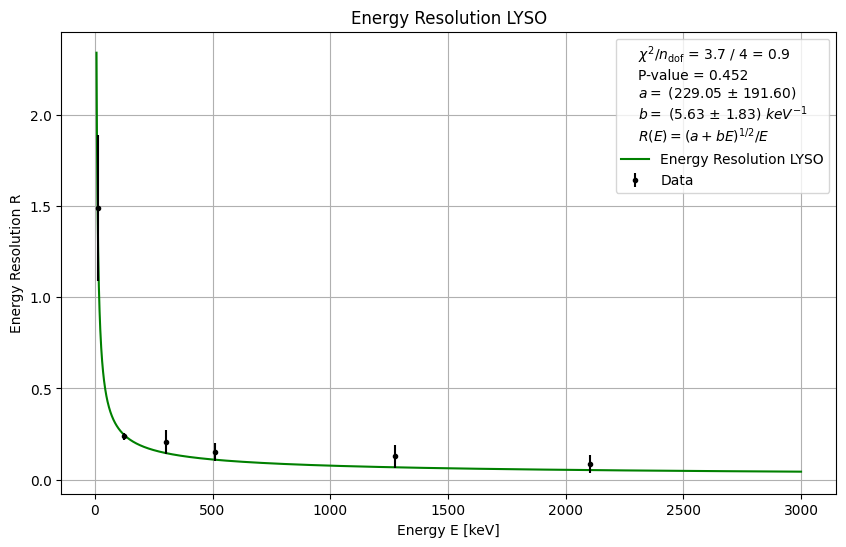

[a, b] = [229.05022167514215, 5.6263090815009384]
[1.4900300005318707, 0.2373173514413952, 0.20481975150589427, 0.15041141708042727, 0.12693043531168163, 0.08763678402687483]
[0.40189559310804385, 0.018435951134908698, 0.06461082183506217, 0.04837138522954551, 0.06506996211474787, 0.049844575538537855]


In [42]:
def Knoll_func(x, a, b):
    return np.sqrt(a+b*x)/x

ls7 = LeastSquares(energia1, R, err_R, Knoll_func)
m7 = Minuit(ls7, a=1, b=1)
m7.migrad()
m7.hesse()
display(m7)

plt.subplots(figsize=(10, 6))
xaxis = np.linspace(7, 3000, 3000)
yaxis = Knoll_func(xaxis, *m7.values)
plt.plot(xaxis, yaxis, label='Energy Resolution LYSO', color='green')
plt.errorbar(energia1, R, err_R, fmt='.', linestyle='', color='black', label='Data')
plt.xlabel('Energy E [keV]')
plt.ylabel('Energy Resolution R')

fit_info = [f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m7.fval:.1f} / {m7.ndof:.0f} = {m7.fval/m7.ndof:.1f}",]
p_value = (1. - chi2.cdf(m7.fval, df=m7.ndof))
fit_info.append(f"P-value = {p_value:.3f}")
fit_info.append('$a = $ ({0:.2f} $\\pm$ {1:.2f})'.format(m7.values['a'], m7.errors['a']))
fit_info.append('$b = $ ({0:.2f} $\\pm$ {1:.2f})'.format(m7.values['b'], m7.errors['b']) + ' $keV^{-1}$')
fit_info.append(r'$R(E) = (a+bE)^{1/2}/E$')
plt.legend(title="\n".join(fit_info), frameon=True)

plt.title('Energy Resolution LYSO')
plt.grid()
plt.savefig('risoluzione_energetica_LYSO.png')
plt.show()

print(f'[a, b] = [{m7.values["a"]}, {m7.values["b"]}]')
print(f'[{R[0]}, {R[1]}, {R[2]}, {R[3]}, {R[4]}, {R[5]}]')
print(f'[{err_R[0]}, {err_R[1]}, {err_R[2]}, {err_R[3]}, {err_R[4]}, {err_R[5]}]')